## Modules

In [1]:
import datetime as dt
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import numpy as np
from urllib import request

In [2]:
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
from matplotlib.collections import PolyCollection
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
warnings.filterwarnings("ignore")

## Download Data

In [5]:
df = pd.read_csv(os.getcwd() + "/Data/GDPC1.csv")
print(df)

           DATE      GDPC1
0    1947-01-01   2033.061
1    1947-04-01   2027.639
2    1947-07-01   2023.452
3    1947-10-01   2055.103
4    1948-01-01   2086.017
..          ...        ...
291  2019-10-01  19253.959
292  2020-01-01  19010.848
293  2020-04-01  17302.511
294  2020-07-01  18596.521
295  2020-10-01  18794.426

[296 rows x 2 columns]


In [6]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")
df = df["1949-01-01":"2019-10-01"]
print(df)

                GDPC1
DATE                 
1949-01-01   2105.562
1949-04-01   2098.380
1949-07-01   2120.044
1949-10-01   2102.251
1950-01-01   2184.872
...               ...
2018-10-01  18813.923
2019-01-01  18950.347
2019-04-01  19020.599
2019-07-01  19141.744
2019-10-01  19253.959

[284 rows x 1 columns]


## Data Overview

In [7]:
def graph_plot(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(data, color = "darkblue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP")
    ax1.set_title("Original Series", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(data.pct_change() * 100, color = "darkblue")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Real GDP Growth")
    ax2.set_title("Original Series (percent change)", loc = "left")
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

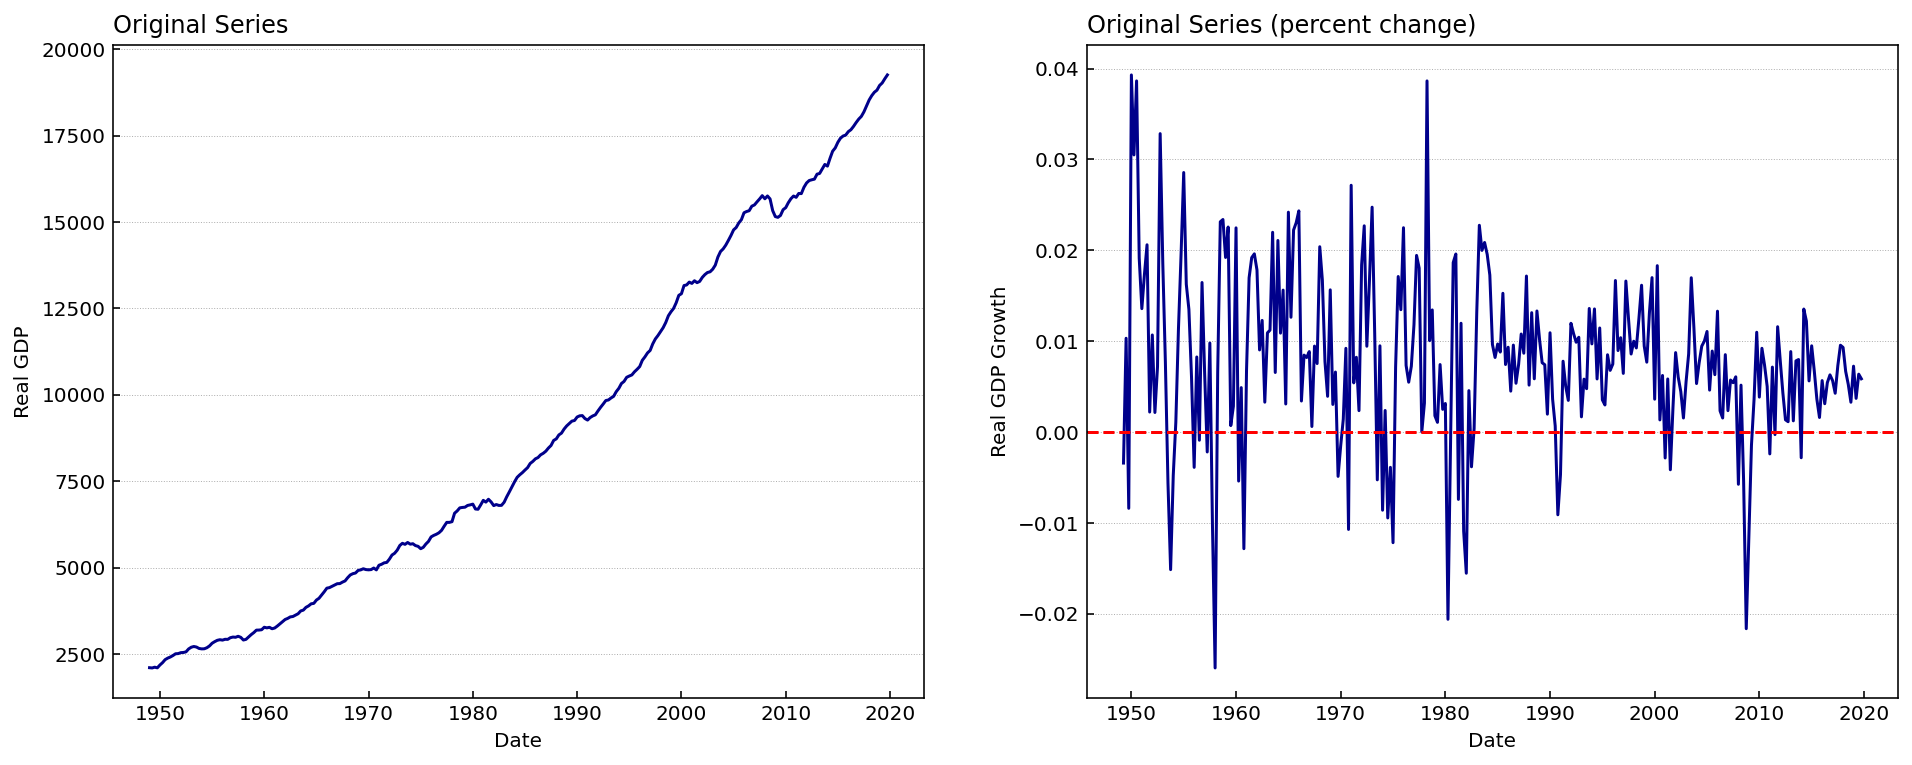

In [8]:
graph_plot(df)

In [9]:
df = df.pct_change().dropna() * 100

## Stationarity Test

In [10]:
# KPSS test
# null hypothesis : series is stationary
# alternate hypothesis : series not stationary (unit root)
# reject null hypothesis if p-value <= 0.05
def kpss_test(data):
    d = 0
    kpss_test = kpss(data.dropna())
    test_statistic, p_value, crit_value = kpss_test[0], kpss_test[1], kpss_test[3]["5%"]
    while test_statistic > crit_value:
        data = data.diff()
        kpss_test = kpss(data.dropna())
        test_statistic, p_value, crit_value = kpss_test[0], kpss_test[1], kpss_test[3]["5%"]
        d = d + 1
    else:
        print("Kwiatkowski-Phillips-Schmidt-Shin  test results")
        print("-> test statistic: " + str(round(test_statistic, 2)))
        print("-> critical value: " + str(round(crit_value, 2)))
        print("-> p-value: " + str(round(p_value, 2)))
        print("-> order of differencing required: " + str(d))
    return d

In [11]:
d_kpss = kpss_test(df)

Kwiatkowski-Phillips-Schmidt-Shin  test results
-> test statistic: 0.05
-> critical value: 0.46
-> p-value: 0.1
-> order of differencing required: 1


In [12]:
# ADF test
# null hypothesis : series not stationary (unit root)
# alternate hypothesis : series is stationary
# reject null hypothesis if p-value <= 0.05
def adf_test(data):
    d = 0
    adf_test = adfuller(data.dropna())
    test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
    while test_statistic > crit_value:
        data = data.diff()
        adf_test = adfuller(data.dropna())
        test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
        d = d + 1
    else:
        print("Augmented-Dickey-Fuller test results")
        print("-> test statistic: " + str(round(test_statistic, 2)))
        print("-> critical value: " + str(round(crit_value, 2)))
        print("-> p-value: " + str(round(p_value, 2)))
        print("-> order of differencing required: " + str(d))
    return d

In [13]:
d_adf = adf_test(df)

Augmented-Dickey-Fuller test results
-> test statistic: -8.4
-> critical value: -2.87
-> p-value: 0.0
-> order of differencing required: 0


In [14]:
def adf_plot(data, d):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    i = 0
    while i != d:
        data = data.diff().dropna()
        i = i + 1
    ax1.plot(data, color = "darkblue")
    ax1.axhline(y = 0, color = "red", linestyle = "--")
    ax1.set_xlabel("Date")
    ax1.set_title("Differenced Series (d=%d)"%(d), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    plot_acf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
             vlines_kwargs = {"colors": "darkblue"}, lags = int(len(data)) - 1, use_vlines = False)
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Correlation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    for item in ax2.collections:
        if type(item) == PolyCollection:
            item.set_facecolor("blue")
    return data

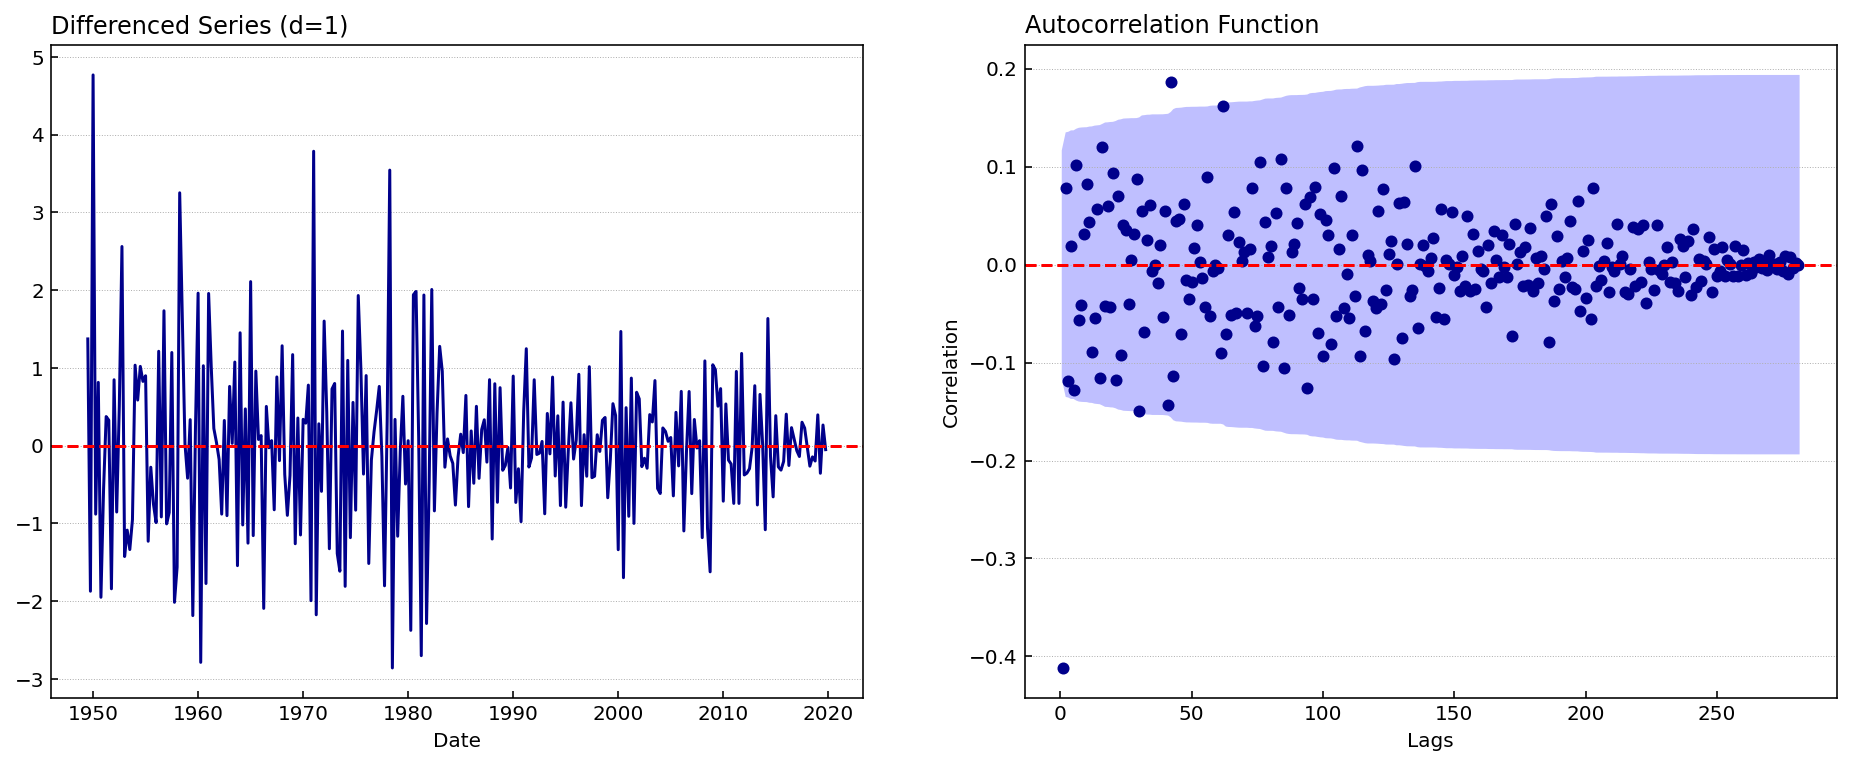

In [15]:
df_diff = adf_plot(df, d_kpss)

## Export Training and Test Data

In [16]:
X = df.copy()
training, testing = X["1949-01-01":"2018-10-01"], X["2019-01-01":"2019-10-01"]

In [17]:
training.to_csv(os.getcwd() + "/Data/training.csv", index = True)
testing.to_csv(os.getcwd() + "/Data/testing.csv", index = True)